In [19]:
import numpy as np
import copy
from scipy import misc
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, CyclicLR, ReduceLROnPlateau, LinearLR, ExponentialLR
import random
from torch.autograd.functional import jacobian#, hessian
# import AUTOGRAD.FUNCTIONAL.JACOBIAN as jacobian
import time
import os
path = os.getcwd()
import json
from visuals import display_it

import matplotlib as mpl
%matplotlib inline
# from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt # type: ignore
mpl.rcParams['legend.fontsize'] = 10
torch.set_default_dtype(torch.float64)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [3]:
from functions import ChesneyScott, exp_solution
from derivation import Grad, Grad_Hess
from equation import semilinear
from coeff import OU_drift_semi, custom_diff, zero_discount, f_driver, exponential_terminal

In [4]:
pde_params={'dim':2,
            'kappa':torch.tensor([0.,1.,0.8,0.6,0.4,0.5,0.3,0.2,0.1,0.7]).to(device), # The first kappa=0 because the drift of wealth process is zero
            'theta':torch.tensor([0.,0.4,0.2,0.3,0.4,0.5,0.4,0.3,0.2,0.1]).to(device),
            # 'nu':torch.tensor([0.02,0.015,0.11,0.12,0.01,0.013,0.14,0.14,0.01]).to(device), #Hung's coefficient
            'nu':torch.tensor([0.,0.2,0.15,0.11,0.12,0.1,0.13,0.14,0.14,0.1]).to(device), # we do not like vanishing diffusion coefficient
            # 'lb':torch.tensor([0.,0.15,0.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15]).to(device),   Hung's params
            'lb':torch.tensor([0.,1.5,1.11,0.12,0.13,0.15,0.11,0.12,0.13,0.15]).to(device), # New params Make closed form solution more sensitive to time
            # 'lb':torch.tensor([0.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]).to(device), # CS test
            'rho':torch.tensor([0.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]).to(device),
            'eta':torch.tensor([.5]).to(device),
            'T': 1.,#torch.tensor([1.]).to(device),
            }

In [5]:
cs = ChesneyScott(pde_params)
cs.theta,cs.nu,cs.lb,cs.kappa,cs.eta

(tensor([0.0000, 0.4000]),
 tensor([0.0000, 0.2000]),
 tensor([0.0000, 1.5000]),
 tensor([0., 1.]),
 tensor([0.5000]))

In [6]:
input = torch.Tensor([[0.,1.,pde_params['theta'][1]],[0.,1.,.195865],[0.,1.,.2]])
input

tensor([[0.0000, 1.0000, 0.4000],
        [0.0000, 1.0000, 0.1959],
        [0.0000, 1.0000, 0.2000]])

In [7]:
cs_val = cs(input)-1
print("{:.8f}, {:.7f}, {:.7f}".format(cs_val[0].item(),cs_val[1].item(),cs_val[2].item()))

-0.50156831, -0.5513028, -0.5504669


In [8]:
torch.sqrt(torch.pow(cs.kappa,2)+ torch.pow(cs.nu*cs.lb,4)),torch.sqrt(torch.pow(cs.kappa,2)+ torch.pow(cs.nu*cs.lb,4))

(tensor([0.0000, 1.0040]), tensor([0.0000, 1.0040]))

In [28]:
lb_norm2 = -0.5*torch.pow(pde_params['lb'][:pde_params['dim']],2).sum()
merton = exp_solution(pde_params,lb_norm2)

In [29]:
merton_val = merton(input)-1
print("{:.7f}, {:.7f}, {:.7f}".format(merton_val[0].item(),merton_val[1].item(),merton_val[2].item()))

-0.1969117, -0.1969117, -0.1969117


In [30]:
t0 = time.time()
num_samples = 2**16
num_time_intervals = 30
max_dim = 10
size = num_samples* max_dim * num_time_intervals
iid = torch.randn(size=[size]).to(device)
print("It takes {:.0f} ms to generate {:,} iid samples.".format(round(1000*(time.time()-t0),6),size))

It takes 244 ms to generate 19,660,800 iid samples.


In [46]:
sim_params={'num_samples':2**12,
        'num_time_intervals': 10,
        'iid':iid,
        'start' : torch.tensor([0.]),  
        'end' : torch.tensor([1.0]),
        'num_neurons':6
        }

In [47]:
m = OU_drift_semi(pde_params)
optimal_diff = m.lb_norm/pde_params['eta']
semi_diff_opt = custom_diff(pde_params,optimal_diff)
k = zero_discount(pde_params)
g = exponential_terminal(pde_params)
F = f_driver(pde_params)

/Users/arashfahim/Documents/GitHub/Deep-Schemes-for-Control/coeff.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.nu = torch.tensor(params['nu'][0:self.dim]).clone().detach().to(device)
/Users/arashfahim/Documents/GitHub/Deep-Schemes-for-Control/coeff.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.kappa = torch.tensor(params['kappa'][0:self.dim]).clone().detach().to(device)
/Users/arashfahim/Documents/GitHub/Deep-Schemes-for-Control/coeff.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.theta = torch.tensor(p

In [48]:
semi = semilinear(semi_diff_opt,m,F,k,g,pde_params,sim_params)

/Users/arashfahim/Documents/GitHub/Deep-Schemes-for-Control/samplepaths.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(sim['start']).clone().detach().to(device)
/Users/arashfahim/Documents/GitHub/Deep-Schemes-for-Control/samplepaths.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(sim['end']).clone().detach().to(device)


In [49]:
semi.train(lr=1e-2,delta_loss=1e-10,max_num_epochs=5000)

At epoch 1, mean loss is 1.14E+02.
Training this epoch takes 56.46 ms. So far: 58.69 ms in training.


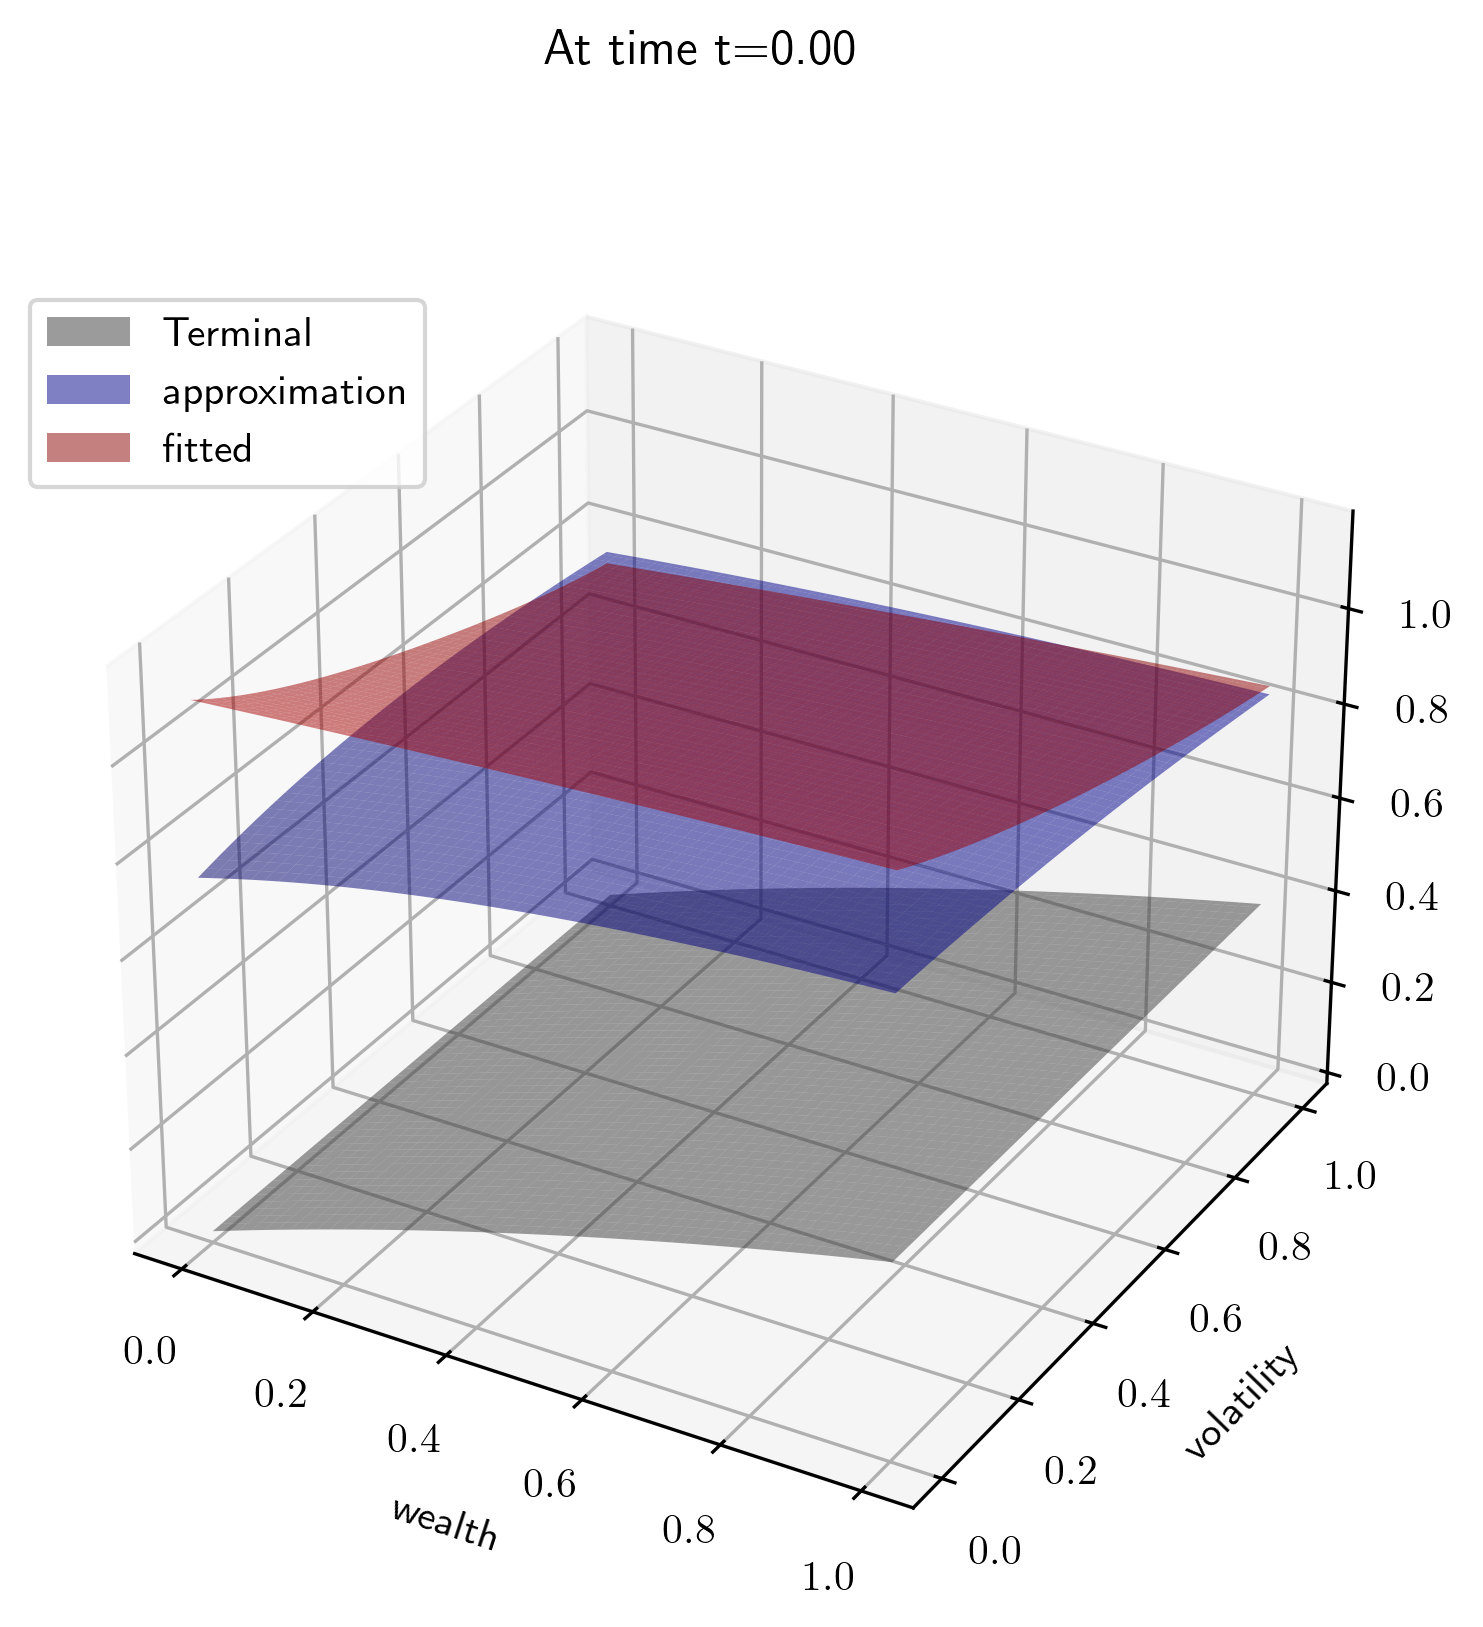

In [ ]:
display_it(semi);

In [ ]:
torch.abs((semi.Y0(torch.tensor([[1.,0.]]))-merton(torch.tensor([[0.,1.,0.]])))/merton(torch.tensor([[0.,1.,0.]])))*100

tensor([[16.5551]], grad_fn=<MulBackward0>)

In [ ]:
m = OU_drift_semi(pde_params)
optimal_cs_diff = lambda x: torch.sqrt(torch.pow(m.lb*x[:,1:],2).sum(axis=1))/pde_params['eta']
semi_diff_opt = custom_diff(pde_params,optimal_cs_diff)
k = zero_discount(pde_params)
g = exponential_terminal(pde_params)
F = f_driver(pde_params)

/Users/arashfahim/Documents/GitHub/Deep-Schemes-for-Control/coeff.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.nu = torch.tensor(params['nu'][0:self.dim]).clone().detach().to(device)
/Users/arashfahim/Documents/GitHub/Deep-Schemes-for-Control/coeff.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.kappa = torch.tensor(params['kappa'][0:self.dim]).clone().detach().to(device)
/Users/arashfahim/Documents/GitHub/Deep-Schemes-for-Control/coeff.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.theta = torch.tensor(p

In [ ]:
semics = semilinear(semi_diff_opt,m,F,k,g,pde_params,sim_params)

/Users/arashfahim/Documents/GitHub/Deep-Schemes-for-Control/samplepaths.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(sim['start']).clone().detach().to(device)
/Users/arashfahim/Documents/GitHub/Deep-Schemes-for-Control/samplepaths.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(sim['end']).clone().detach().to(device)


In [ ]:
semics.train(lr=1e-2,delta_loss=1e-10,max_num_epochs=5000)

At epoch 1, mean loss is 8.44E+00.
Training this epoch takes 1,792.05 ms. So far: 1,792.59 ms in training.
At epoch 166, mean loss is 7.65E-01.
Training this epoch takes 771.63 ms. So far: 150,851.42 ms in training.
At epoch 332, mean loss is 3.85E-01.
Training this epoch takes 546.05 ms. So far: 287,928.82 ms in training.
At epoch 498, mean loss is 2.96E-01.
Training this epoch takes 727.32 ms. So far: 557,010.56 ms in training.
Training took 500 epochs and 558,248.0 ms and the final loss is 2.95E-01.


In [ ]:
semics.Yt(torch.tensor([[0.,1.,2.]])),semics.Y0(torch.tensor([[1.,2.]]))

(tensor([[1.0338]], grad_fn=<AddmmBackward0>),
 tensor([[0.9440]], grad_fn=<AddmmBackward0>))

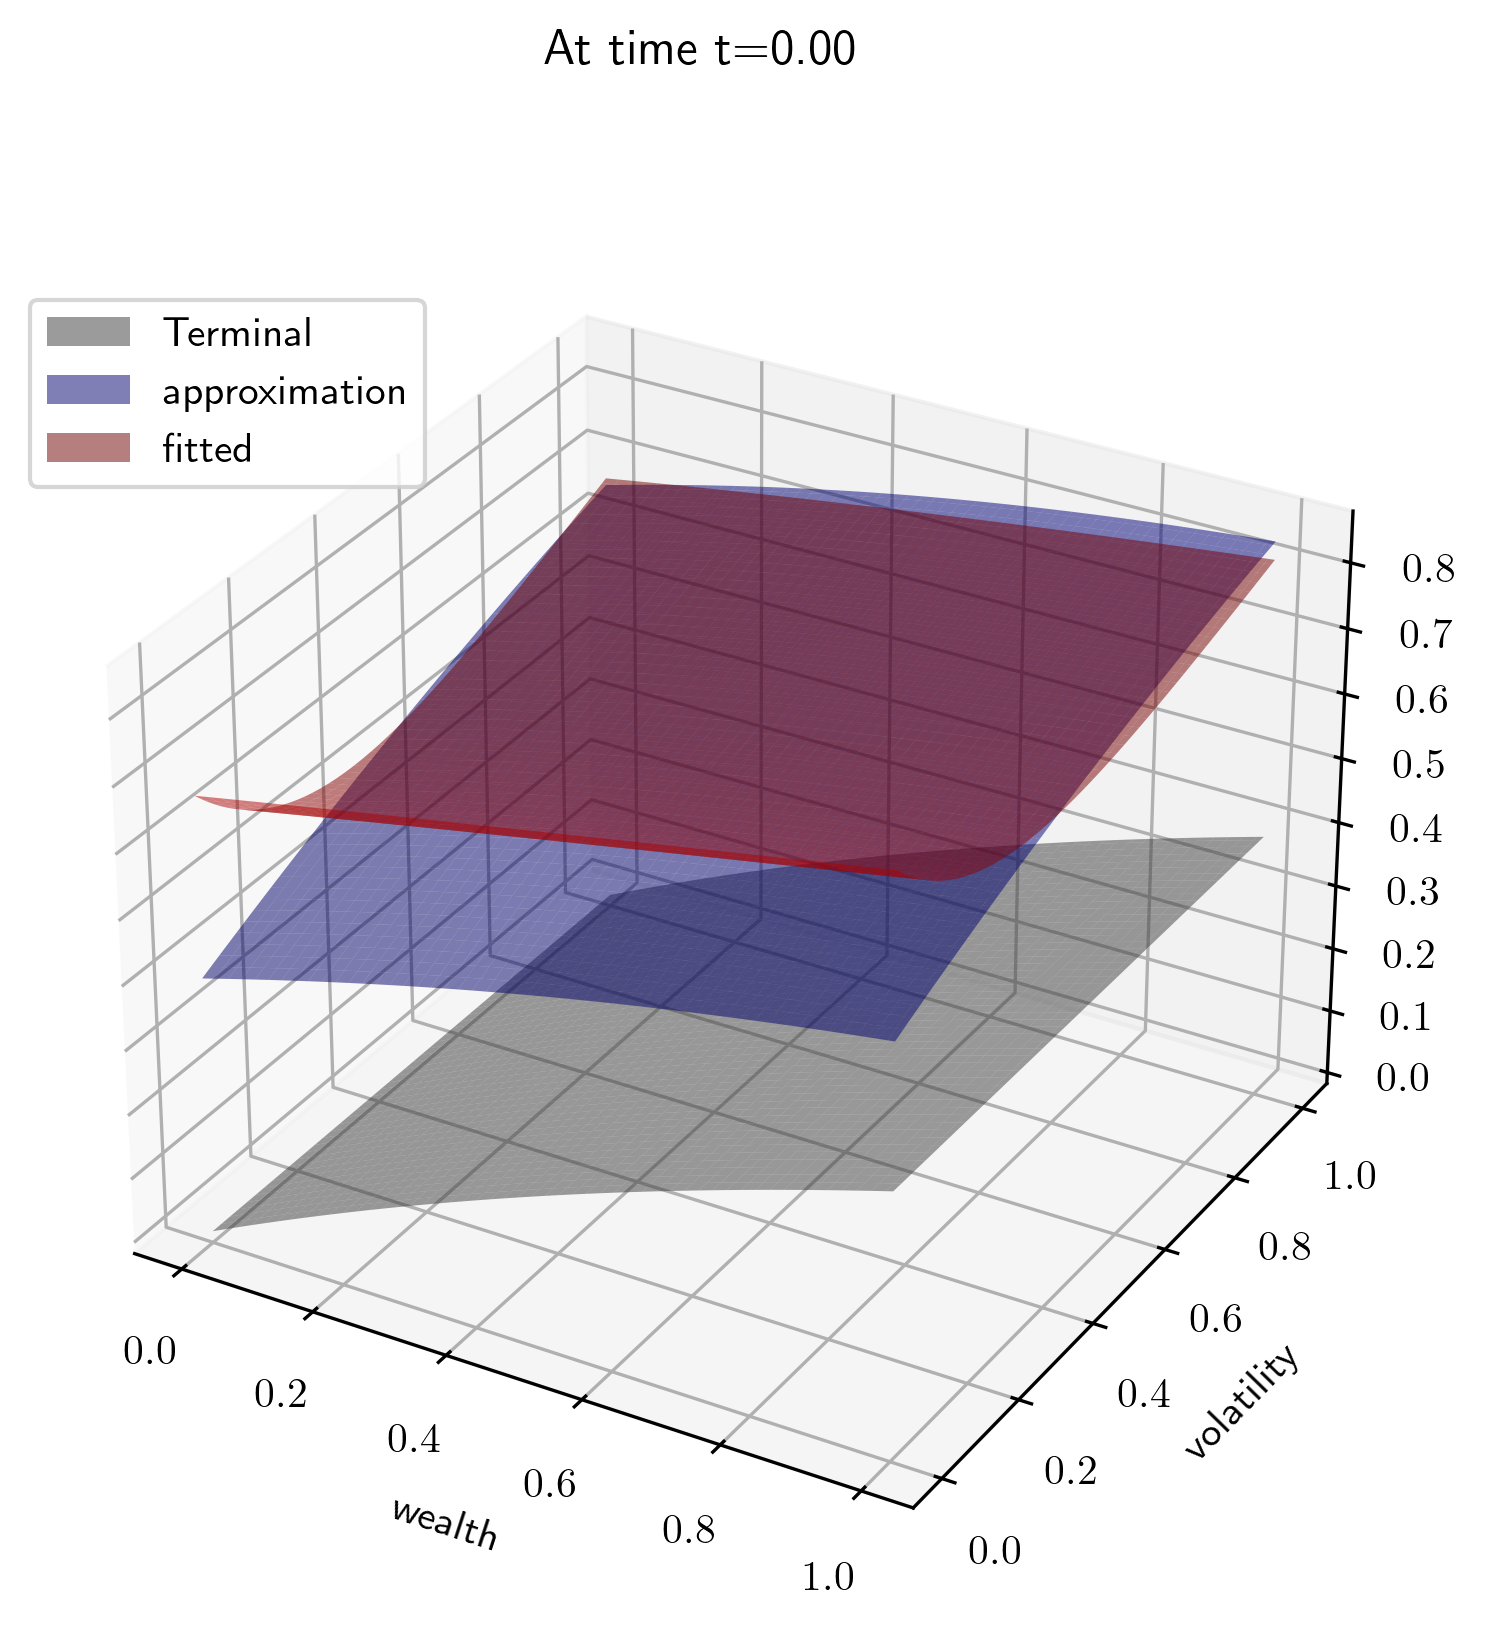

In [ ]:
display_it(semics);